## Bayesian hyperparameter optimization 

Train a model with varying parameters trying to find the best of them.

In [1]:
import torch
import numpy as np
import csv
import os
import datetime
import pandas as pd
import ast
from timeit import default_timer as timer

import context
from mlnowcasting.models.architectures.example_model import get_model
from mlnowcasting.models.params.example_params import params
from mlnowcasting.models.losses.example_loss import get_loss_fx
from mlnowcasting.utils.torch_trainer import Torch_Trainer
from mlnowcasting.utils.metrics import events_specific_metric, _get_metric_names
from mlnowcasting.utils.utils import any2reflectivity
from mlnowcasting.utils.plot_utils import plot_obs_pred

import hyperopt
from hyperopt import hp
from hyperopt.pyll.stochastic import sample
from hyperopt import tpe
from hyperopt import Trials
from hyperopt import fmin
from hyperopt import STATUS_OK


/s/chopin/d/proj/jcuomo/699/repository


### Set the basic configuration

In [2]:
global directory
global out_file

# where the results are going to be saved
directory = './hyp_opt/optimization_1/'

# training and validation datasets
dataset     = '../data/datasets/example_dataset.npy'
val_dataset = '../data/datasets/example_dataset.npy'

N = 0 # for each trianing a prediction plot is saved. This is the event from the val_dataset that it's used.
th_dbz = 20 # reflectivity threshold for the metrics
max_trials = 3 # number of trials in the optimization

In [3]:
# You can use a metric instead of the loss fx to decide where the parameters should 'move'
use_metric  = True # if False the loss fx is used
metric_name = 'CSI'
metric_sign = -1 # if the metric the higher the better, inverted using a -1, else use a 1
print("Available metrics:",_get_metric_names())

Available metrics: ['MSE', 'CSI', 'FAR', 'POD', 'ETS', 'ACC', 'MAE', 'SSIM']


Create the result file, where for each trial an entry is appended

In [4]:
# Keep track of results
bayes_trials = Trials()

# optimization algorithm
tpe_algorithm = tpe.suggest

# Dir to save results
try:
    os.mkdir(directory)
except:
    pass
out_file = directory+'results.csv'
of_connection = open(out_file, 'w')
writer = csv.writer(of_connection)

# Write the headers to the file
writer.writerow(['loss', 'metric', 'params', 'train_time', 'status'])
of_connection.close()

### Define the parameters

In [5]:
# create the search space
# check here all possible expressions: https://github.com/hyperopt/hyperopt/wiki/FMin#21-parameter-expressions
params = {# training params
          'weight_decay'   : 0, 
          'eps'            : 1e-08, 
          'beta1'          : 0.9, 
          'beta2'          : 0.999, 
          'lr'             : 0.0001, 
          'lr_steps'       : 3, 
          'max_epochs'     : 20, 
          'batch'          : 4,
          'log_interval'   : 10, 
          'th'             : 20,
          'show'           : True,
          'fix'            : True,
          'save_filename'  : None, 
          # model params
          'in_frames'      : 16,
          'out_frames'     : 16, 
          'dropout'        : hp.uniform('dropout', 0.0,0.3), 
          'n_filter'       : hp.choice('n_filter', [64,128])
           }   
    

Main function that does the training and most importantly returns a dictionary where the key 'loss' determines which variable is used to explore the search space.

In [6]:
def objective(params):
    global directory
    global out_file
    global param
    
    T=Torch_Trainer(dataset, val_dataset, get_model, get_loss_fx)

    start = timer()
    loss = T.train(params)
    run_time = timer() - start
    
    with torch.no_grad():
        device = torch.device("cuda:0")
        data = np.load(val_dataset)
        mid = int(data.shape[1]/2)
        fi = params['in_frames']
        fo = params['out_frames']

        context = np.expand_dims(data[:, mid-fi:mid],1)/255
        target  = np.expand_dims(data[:, mid:mid+fo],1)/255
        target  = torch.tensor(target).to(device).float()
        predict = T.model(torch.tensor(context).to(device).float())
        target  = any2reflectivity(target)
        predict = any2reflectivity(predict)
        metric  = events_specific_metric(target, predict, metric_name=metric_name, th_dbz=th_dbz)
        fig = plot_obs_pred(target[N,0],predict[N,0], N=5, cmap='darts')
        fig.savefig(directory+str(metric)+'_'+datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S.png"))
    
    # Write to the csv file ('a' means append)
    of_connection = open(out_file, 'a')
    writer = csv.writer(of_connection)
    writer.writerow([loss, metric, params, run_time, STATUS_OK])
    if use_metric:
        adjusted_metric = metric_sign * metric # metric_sign = 1 or -1
        return {'loss': adjusted_metric, 'params': params,'train_time': run_time, 'status': STATUS_OK}
    else:
        return {'loss': loss, 'params': params,'train_time': run_time, 'status': STATUS_OK}
        

### Run the trials

Train Epoch: 10 Loss: 0.200108 Val_Loss: 0.199884                            
 67%|██████▋   | 2/3 [00:23<00:10, 10.57s/trial, best loss: -0.1092529296875]

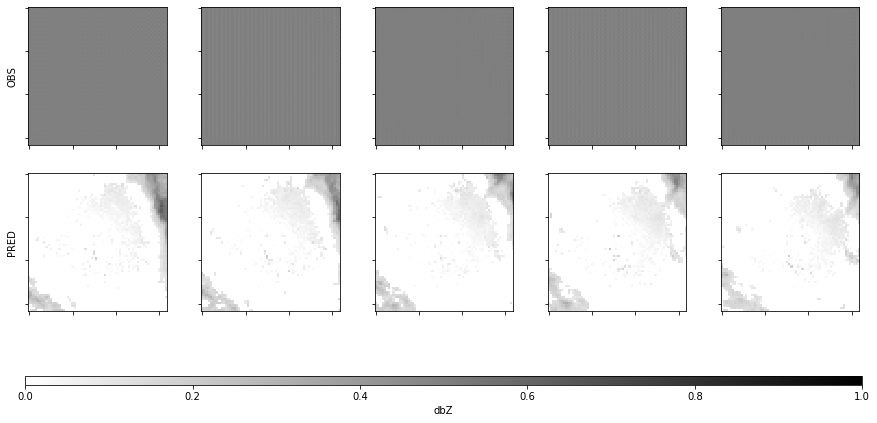

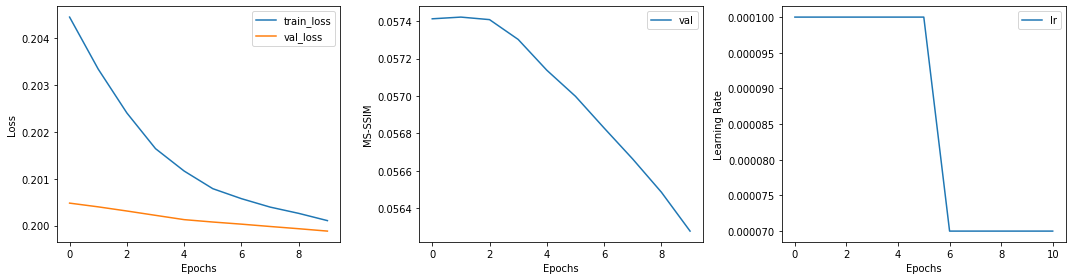

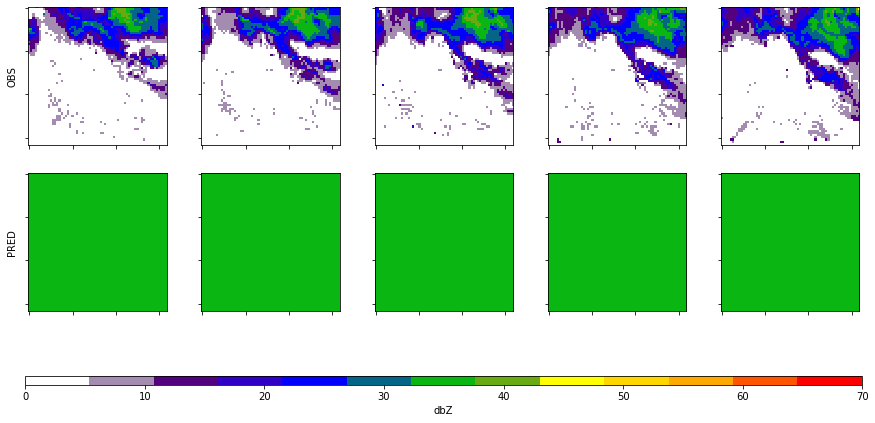

100%|██████████| 3/3 [00:28<00:00,  9.42s/trial, best loss: -0.1092529296875]


In [7]:
best = fmin(fn = objective, 
            space = params, 
            algo = tpe.suggest, 
            max_evals = max_trials, 
            trials = bayes_trials)

## Show the results

Load the results file and display it

In [8]:
results = pd.read_csv(out_file)

# Sort with best scores on top and reset index for slicing
results.sort_values('loss', ascending = True, inplace = True)
results.reset_index(inplace = True, drop = True)

bayes_params = pd.DataFrame(columns = list(ast.literal_eval(results.loc[0, 'params']).keys()),
                            index = list(range(len(results))))

# Add the results with each parameter a different column
for i, params in enumerate(results['params']):
    bayes_params.loc[i, :] = list(ast.literal_eval(params).values())
    
bayes_params['loss'] = results['loss']
bayes_params['metric'] = results['metric']

bayes_params

,batch,beta1,beta2,dropout,eps,fix,in_frames,log_interval,lr,lr_steps,max_epochs,n_filter,out_frames,save_filename,show,th,weight_decay,loss,metric
0,4,0.9,0.999,0.0562485,1e-08,True,16,10,0.0001,3,20,64,16,None,True,20,0,0.187835,0.109253
1,4,0.9,0.999,0.0868315,1e-08,True,16,10,0.0001,3,20,64,16,None,True,20,0,0.199487,0.109253
2,4,0.9,0.999,0.117939,1e-08,True,16,10,0.0001,3,20,128,16,None,True,20,0,0.230228,0.109253


Show only some important parameters (maybe those that were tuned) and sort them

In [9]:
bayes_params[['weight_decay','lr','n_filter','dropout','loss','metric']].sort_values(by=['metric'])

,weight_decay,lr,n_filter,dropout,loss,metric
0,0,0.0001,64,0.0562485,0.187835,0.109253
1,0,0.0001,64,0.0868315,0.199487,0.109253
2,0,0.0001,128,0.117939,0.230228,0.109253
